## python and tensorflow
This script include 3 steps
1. collect the data
2. sellect and format the data


In [1]:
import json
import os 
import fnmatch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

In [2]:
## read data object
class Data:
    def __init__(self):
        self.workouts = []
        self.users = []

    def findFile(self,rootdir):
        fileList = os.listdir(rootdir)
        fldFileList = fnmatch.filter(fileList, '*.user.json')
        for i in range(len(fldFileList)):
            fldFileList[i] = fldFileList[i][0:-10]
        return fldFileList


    def findData(self,rootdir,fileName):
        with open(rootdir+"extf/"+fileName+".xx","r") as reader:
            self.workouts.append(json.loads(reader.read()))
        with open(rootdir+fileName+".user.json","r") as reader:
            self.users.append(json.loads(reader.read()))

In [3]:
## collect the data
## jsonload folder include .user.json /extf/.xx
rootdir = "/usr/app/Data/coros_data/jsonload/"
data = Data()
fileNamelist = data.findFile(rootdir)
for i in range(50,100,1):
    data.findData(rootdir,fileNamelist[i])


2500


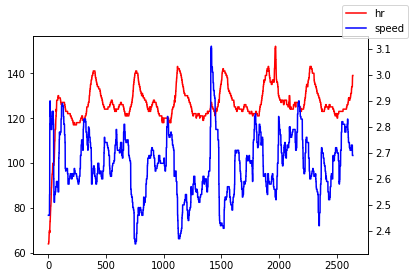

In [4]:
## select the data
i = 8
hr = np.zeros([len(data.workouts[i]),1])
sp = np.zeros([len(data.workouts[i]),1])

for j in range(len(data.workouts[i])):
    hr[j] = data.workouts[i][j]['hr']
    sp[j] = data.workouts[i][j]['sp']

startIndex = 0
endIndex = -1
fig, ax1 = plt.subplots()
ax1.plot(range(hr[startIndex:endIndex,:].shape[0]),hr[startIndex:endIndex,:],color='red',label='hr')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(range(sp[startIndex:endIndex,:].shape[0]),sp[startIndex:endIndex,:],color='blue',label='speed')
fig.legend()

## cut the data (sp to sp2)
startIndex = 0
endIndex = 2500
dataAmount = endIndex - startIndex
sp2 = np.zeros([dataAmount,1])
sp2 = sp[startIndex:endIndex,0]
print(sp2.shape[0])

In [5]:
def predicF(dataDiffIndex,b,gain,sp2,tauTable,kTable,y,hr,startIndex,endIndex,thresholdTable):
    y = np.zeros([sp2.shape[0]-dataDiffIndex,1])
    for i in range(y.shape[0]):
        y[i] = hr[startIndex]
    for i in range(sp2.shape[0]-dataDiffIndex):
        spDiff = sp2[i+dataDiffIndex] - sp2[i]
        if spDiff > 0:
            index = 0
        elif spDiff < 0:
            index = 1
        else:
            continue
        
        if sp2[i] <= thresholdTable[0]:
            index_x = 0
        elif sp2[i] < thresholdTable[1] and sp2[i] > thresholdTable[0]:
            index_x = 1
        elif sp2[i] < thresholdTable[2] and sp2[i] > thresholdTable[1]:
            index_x = 2
        elif sp2[i] < thresholdTable[3] and sp2[i] > thresholdTable[2]:
            index_x = 3
        elif sp2[i] < thresholdTable[4] and sp2[i] > thresholdTable[3]:
            index_x = 4
        else:
            index_x = 5
                
        tau = tauTable[index_x,index]
        k = kTable[index_x,index]
        # for t in range(sp2.shape[0]-dataDiffIndex-i):
        for t in range(800):
            if t+i < sp2.shape[0]-dataDiffIndex:
                y[i+t] += (spDiff*gain*(k-k*np.exp(-t/tau)))
    return y

def predicOfError(dataDiffIndex,b,gain,sp2,tauTable,kTable,y,hr,startIndex,endIndex,thresholdTable):
    y = predicF(dataDiffIndex,b,gain,sp2,tauTable,kTable,y,hr,startIndex,endIndex,thresholdTable)
    err = np.zeros([sp2.shape[0]-dataDiffIndex,1])
    err = y - hr[startIndex:endIndex-dataDiffIndex]
    return (np.dot(err.T,err)/err.shape[0])

## model parameter
tauTable = np.zeros([6,2])
tauTable[0,0] = 9.4818
tauTable[1,0] = 10.193
tauTable[2,0] = 13.659
tauTable[3,0] = 18.618
tauTable[4,0] = 38.192
tauTable[5,0] = 55.974

tauTable[0,1] = 27.358
tauTable[1,1] = 27.365
tauTable[2,1] = 26.741
tauTable[3,1] = 30.865
tauTable[4,1] = 48.114
tauTable[5,1] = 81.693

kTable = np.zeros([6,2])
kTable[0,0] = 9.2583
kTable[1,0] = 11.264
kTable[2,0] = 10.006
kTable[3,0] = 12.807
kTable[4,0] = 17.753
kTable[5,0] = 32.911

kTable[0,1] = 7.9297
kTable[1,1] = 9.8561
kTable[2,1] = 8.9772
kTable[3,1] = 12.087
kTable[4,1] = 12.087
kTable[5,1] = 25.733

thresholdTable = np.zeros([6,1])
thresholdTable[0] = 0.5
thresholdTable[1] = 1.5
thresholdTable[2] = 2.0
thresholdTable[3] = 2.5
thresholdTable[4] = 3.0
thresholdTable[5] = 3.5

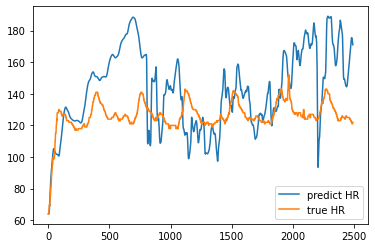

In [10]:
dataDiffIndex  = 7
gain = 1.4
y = np.zeros([dataAmount-dataDiffIndex,1])
y = predicF(dataDiffIndex,0,gain,sp2,tauTable,kTable,y,hr,startIndex,endIndex,thresholdTable)
plt.plot(y,label='predict HR')
plt.plot(hr[startIndex:endIndex-7],label='true HR')
plt.legend()

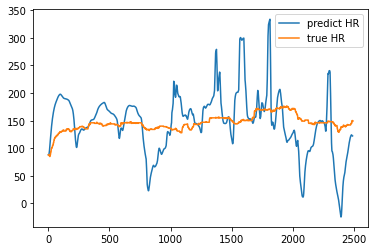

In [8]:
dataDiffIndex  = 9
gain = 1.4
y = np.zeros([dataAmount-dataDiffIndex,1])
y = predicF(dataDiffIndex,0,gain,sp2,tauTable,kTable,y,hr,startIndex,endIndex,thresholdTable)
# print(predicOfError(7,0,1.4,sp2,tauTable,kTable,y,hr,startIndex,endIndex,thresholdTable))
# print(predicOfError(10,0,1,sp2,tauTable,kTable,y,hr,startIndex,endIndex,thresholdTable))
plt.plot(y,label='predict HR')
plt.plot(hr[startIndex:endIndex-7],label='true HR')
plt.legend()


In [63]:
## find optimise paramter
MSE = np.zeros([10,10])
for i in range(10):
    for j in range(10):
        gain = 0.5+i*0.1
        dataDiffIndex = j+1
        b = 0
        MSE[i,j] = (predicOfError(dataDiffIndex,b,gain,sp2,tauTable,kTable,y,hr,startIndex,endIndex,thresholdTable))
print(MSE)
print(MSE.argmin())

[[2535.33147365 2229.37688552 2008.60642939 1799.81153959 1613.07992644
  1437.18547466 1279.96151983 1132.63213418 1002.7929353   881.93113709]
 [2472.62887515 2113.01265694 1857.25021664 1618.81771972 1408.92008075
  1214.69928    1044.50641944  888.63732592  754.9174057   634.19002874]
 [2410.75672589 1999.97393615 1712.25872432 1448.21413369 1219.86216895
  1012.91734401  835.92824737  678.50899301  548.28499905  435.80869735]
 [2349.71502588 1890.26072315 1573.63195244 1288.00078148 1045.90619104
   831.83966667  654.22700361  502.24713546  382.89571534  286.78714293]
 [2289.50377511 1783.87301793 1441.36990098 1138.1776631   887.05214702
   671.466248    499.40268817  359.85175326  258.74955457  187.12536548]
 [2230.12297359 1680.8108205  1315.47256996  998.74477855  743.30003689
   531.79708798  371.45530105  251.32284641  175.84651674  136.82336499]
 [2171.57262132 1581.07413085 1195.93995937  869.70212783  614.64986065
   412.83218663  270.38484224  176.66041491  134.18660186 

## Following is using Ordinary least squares 

In [116]:
## Ordinary least squares y(k) = a1 y(k-1) + a2 y(k-2) + ... + a10 y(k-10) + b0 u(k) + b1 u(k-1) + ... + b10 u(k-10)
## list of data to np.array of data
i = 8
lenOfData = len(data.workouts[i])-10
y = np.array([[0]]*lenOfData)
a = np.array([[0]*21]*lenOfData)

for j in range(len(data.workouts[i])-10):
    y[j][0] = data.workouts[i][j+10]['hr']
    for k in range(10):
        a[j][k] = data.workouts[i][j+k]['hr']
    for k in range(11):
        a[j][k+10] = data.workouts[i][j+k]['sp']

## Ordinary least squares
ata = np.dot(a.transpose(),a)
ataInverse = np.linalg.inv(ata)
aty = np.dot(a.transpose(),y)
x = np.dot(ataInverse,aty)
print(x)

[[-0.01880632]
 [-0.00146077]
 [ 0.01333605]
 [-0.03294502]
 [-0.03229101]
 [-0.02087784]
 [-0.01793579]
 [-0.01266695]
 [ 0.02781855]
 [ 1.0908419 ]
 [ 0.16946276]
 [ 0.55738734]
 [-1.00973874]
 [ 0.50523166]
 [ 0.01210435]
 [ 0.055424  ]
 [ 0.03822382]
 [-0.51484482]
 [ 0.51760124]
 [ 0.01523019]
 [-0.02694425]]


MSE: [[0.15912382]]


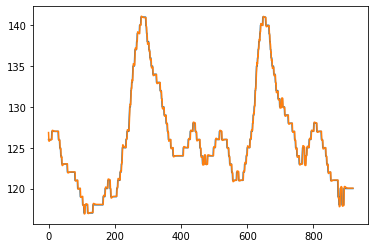

In [24]:
startIndex = 100
endIndex = 1020
ybar = np.dot(a[startIndex:endIndex][:],x)
plt.plot(range(y[startIndex:endIndex][:].shape[0]),y[startIndex:endIndex,:])
plt.plot(range(ybar.shape[0]),ybar)
MSE = np.dot((ybar - y[startIndex:endIndex,:]).T,(ybar - y[startIndex:endIndex,:]))/ybar.shape[0]
print("MSE:",MSE)

MSE: [[12042.29431664]]


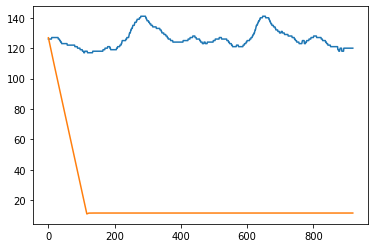

In [25]:
startIndex = 100
endIndex = 1020
a1 = a[startIndex,:]
ykRecord= []
for i in range(startIndex,endIndex):
    yk = np.dot(a1,x)
    ykRecord.append(yk)
    for j in range(9):
        a1[j] = a1[j+1]
    a1[9] = yk
    a1[10:21] = a[i+1,10:21]

plt.plot(range(y[startIndex:endIndex][:].shape[0]),y[startIndex:endIndex,:])
plt.plot(range(len(ykRecord)),ykRecord)
MSE = np.dot((ykRecord - y[startIndex:endIndex,:]).T,(ykRecord - y[startIndex:endIndex,:]))/len(ykRecord)
print("MSE:",MSE)

MSE: [[18.60390539]]


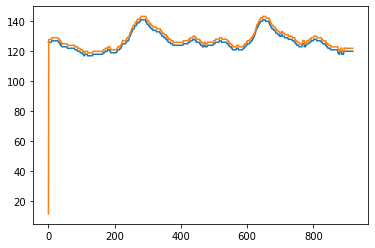

In [26]:
xp = np.concatenate((x[1:10],x[11:21]))
ap = np.zeros([a.shape[0],a.shape[1]-2])
ap[:,0:9] = a[:,1:10]
ap[:,9:19] = a[:,11:21]
startIndex = 100
endIndex = 1020
ybar = np.dot(ap[startIndex:endIndex][:],xp)
plt.plot(range(y[startIndex:endIndex][:].shape[0]),y[startIndex:endIndex][:])
plt.plot(range(ybar.shape[0]),ybar)
MSE = np.dot((ybar - y[startIndex:endIndex,:]).T,(ybar - y[startIndex:endIndex,:]))/ybar.shape[0]
print("MSE:",MSE)

MSE: [[192.50641463]]


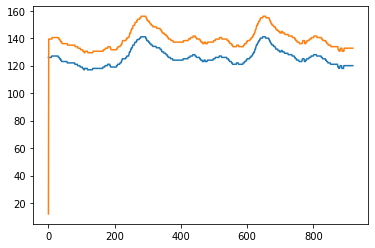

In [27]:
xp = np.concatenate((x[7:10],x[17:21]))
ap = np.zeros([a.shape[0],7])
ap[:,0:3] = a[:,7:10]
ap[:,3:7] = a[:,17:21]
startIndex = 100
endIndex = 1020
ybar = np.dot(ap[startIndex:endIndex][:],xp)
plt.plot(range(y[startIndex:endIndex][:].shape[0]),y[startIndex:endIndex][:])
plt.plot(range(ybar.shape[0]),ybar)
MSE = np.dot((ybar - y[startIndex:endIndex,:]).T,(ybar - y[startIndex:endIndex,:]))/ybar.shape[0]
print("MSE:",MSE)

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [6]:
print(len(train_dataset))
print(len(test_dataset))

57911
14478


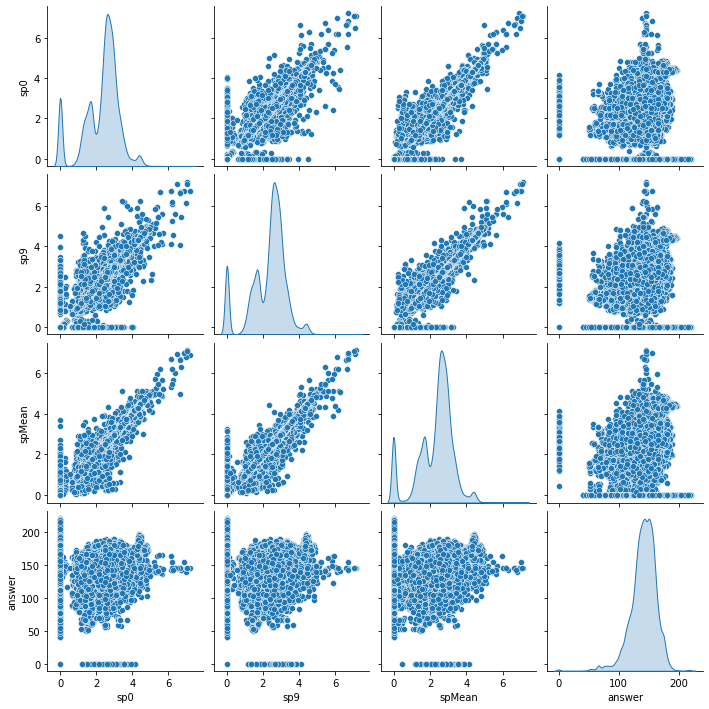

In [18]:
sns.pairplot(train_dataset[['sp0', 'sp9', 'spMean', 'answer']], diag_kind='kde')

In [7]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
age,39.223377,7.557352
gender,0.616118,0.486334
weight,68.829393,10.617349
height,175.729896,8.096113
max_heartrate,184.901055,7.915317
resting_heartrate,67.912625,5.423906
spMean,2.302805,0.972748
answer,140.811418,21.009366
sp0,2.302467,0.979472
sp1,2.302946,0.979143


In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('answer')
test_labels = test_features.pop('answer')

In [25]:
test_features.shape

(14478, 17)

In [9]:
multi_feature = np.array(train_features)

multi_feature_normalizer = preprocessing.Normalization(input_shape=[17,])
multi_feature_normalizer.adapt(multi_feature)

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_hr_model = build_and_compile_model(multi_feature_normalizer)
history = dnn_hr_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,10.356174,10.726443,95
96,10.367628,10.366213,96
97,10.385318,10.483161,97
98,10.342722,10.437473,98
99,10.361844,10.691357,99


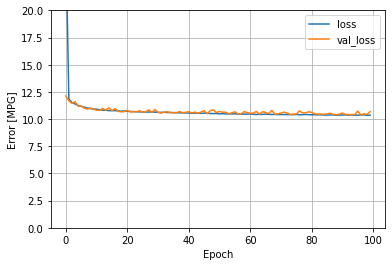

In [12]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [20]:
print(len(test_features))
print(len(test_predictions))
print(len(test_labels))

14478
14478
14478


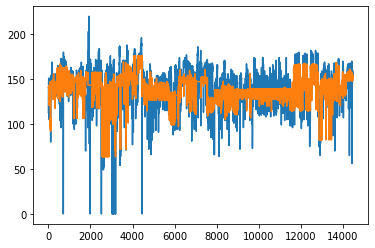

In [21]:
test_predictions = dnn_hr_model.predict(test_features).flatten()
plt.plot(range(len(test_labels)),test_labels)
plt.plot(range(len(test_predictions)),test_predictions)
# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, test_predictions)
# plt.xlabel('True Values [MPG]')
# plt.ylabel('Predictions [MPG]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

In [16]:
test_labels

5        113
10       130
13       131
20       138
21       139
        ... 
72372    150
72373    153
72375    151
72376    149
72377    151
Name: answer, Length: 14478, dtype: int64

In [15]:
test_predictions

array([140.44781, 140.14767, 140.20197, ..., 152.17043, 151.69199,
       151.35849], dtype=float32)